# Avance de proyecto 2: Sistema de recomendación
## Maestría en inteligencia artificial aplicada: Análisis de grandes volúmenes de datos


Equipo:
- Abraham Cabanzo Jimenez A01794355
- Ignacio Antonio Ruiz Guerra A00889972
- Moisés Díaz Malagón A01208580


Este proyecto complementa lo mostrado en el documento escrito de 2da entrega.
A continuación se muestra el uso del dataset MovieLens 1M debido a que como ya se mencionó, para realizar filtro colaborativo necesitamos datos de usuario y ratings, los cuales no contabamos en la base de datos de imdb.

En este documento repetimos la exploración básica pero ahora para familiarizarnos con este set de datos, e implementamos un algoritmo de recomendación complejo utilizando redes neuronales, éste será de tipo filtro colaborativo. Se presentan 3 métricas con las que se trabajará para evaluarlo.

Se implementa también un algoritmo básico utilizando KNeighbors para un sistema de recomendación basado en contenido.

Finalmente se implementa una función que permite utilizar un ensamble de sistemas de recomendación de acuerdo con requerimientos similares a la vida real tal como un arranque en frio.


#### 1. Exploración de base de datos

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import scipy


In [2]:
ratings = pd.read_csv("ratings.dat", sep='::', names=['user_id', 'movie_id', 'rating', 'timestamp'])

/var/folders/t3/2fb0wqk504s68c7h3cwcl1fc0000gn/T/ipykernel_67819/3158531673.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv("ratings.dat", sep='::', names=['user_id', 'movie_id', 'rating', 'timestamp'])


In [3]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
movies = pd.read_csv("movies.dat", sep='::', names=['movie_id', 'movie_title', 'genres'], encoding='latin-1')

/var/folders/t3/2fb0wqk504s68c7h3cwcl1fc0000gn/T/ipykernel_67819/3223006083.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies = pd.read_csv("movies.dat", sep='::', names=['movie_id', 'movie_title', 'genres'], encoding='latin-1')


In [5]:
movies.head()

,movie_id,movie_title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings_length = len(ratings)
unique_movies = ratings['movie_id'].nunique()
unique_users = ratings['user_id'].nunique()


ratings_length, unique_movies, unique_users

(1000209, 3706, 6040)

In [7]:
# ratings por userId
user_ratings_count = ratings[['user_id', 'movie_id']].groupby('user_id').count().reset_index()
user_ratings_count.columns = ['user_id', 'ratings']
user_ratings_count.head()

,user_id,ratings
0,1,53
1,2,129
2,3,51
3,4,21
4,5,198


In [8]:
# promedio de ratings por usuario
round(user_ratings_count['ratings'].mean(),1)

165.6

Text(0, 0.5, 'Cantidad de Ratings')

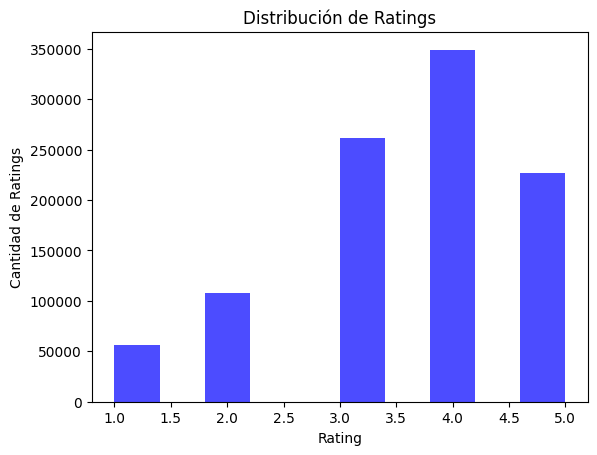

In [9]:
# distribución de ratings
plt.hist(ratings['rating'], bins=10, color='blue', alpha=0.7)
plt.title('Distribución de Ratings')
plt.xlabel('Rating')
plt.ylabel('Cantidad de Ratings')

Text(0.5, 1.0, 'Cantidad de películas calificadas por usuario')

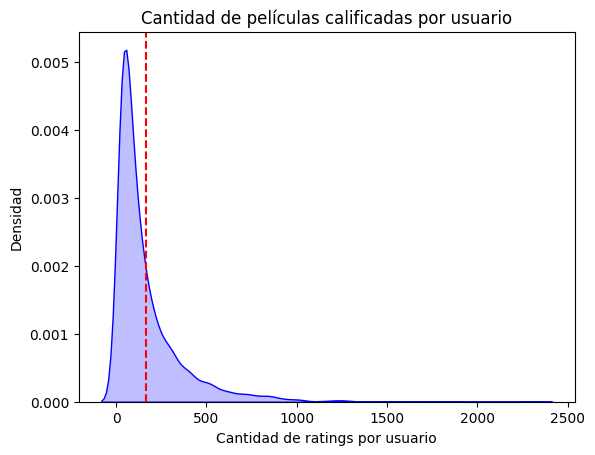

In [10]:

plot = sns.kdeplot(user_ratings_count['ratings'], color='blue', fill=True)
plot.axvline(user_ratings_count['ratings'].mean(), color='red', linestyle='--')
plot.set_xlabel("Cantidad de ratings por usuario")
plot.set_ylabel("Densidad")
plot.set_title("Cantidad de películas calificadas por usuario")

In [11]:
min_rating_movie_idx = ratings.groupby('movie_id')['rating'].mean().idxmin()
print(movies[movies['movie_id'] == min_rating_movie_idx]['movie_title'])

max_rating_movie_idx = ratings.groupby('movie_id')['rating'].mean().idxmax()
print(movies[movies['movie_id'] == max_rating_movie_idx]['movie_title'])

125    Silence of the Palace, The (Saimt el Qusur) (1...
Name: movie_title, dtype: object
777    Gate of Heavenly Peace, The (1995)
Name: movie_title, dtype: object


In [12]:
ratings[ratings['movie_id']==max_rating_movie_idx]

,user_id,movie_id,rating,timestamp
19836,149,787,5,977325719
458840,2825,787,5,972610193
465525,2872,787,5,972423586


In [13]:
# debido a pocas muestras, utilizaremos promedio bayesiano

movies_count_and_mean = ratings.groupby('movie_id')['rating'].agg(['count', 'mean'])
C = movies_count_and_mean['count'].mean() # C: promedio de la cantidad de ratings de todas las peliculas
m = movies_count_and_mean['mean'].mean() # m: promedio de la media de calificaciones de todas las peliculas


def bayesian_avg(ratings):
    # esto se ejecutara para cada pelicula
    N = ratings.count() # cantidad de ratings de una pelicula
    sum_reviews = ratings.sum() # suma de los ratings de una pelicula
    return (C*m + sum_reviews) / (C + N)

ratings_bayesian_avg = ratings.groupby('movie_id')['rating'].agg(bayesian_avg).reset_index()
ratings_bayesian_avg.columns = ['movie_id', 'bayesian_avg_rating']
movie_stats = movies_count_and_mean.merge(ratings_bayesian_avg, on='movie_id')

In [14]:
# observamos las mejores peliculas rankeadas usando promedio bayesiano
pd.merge(movie_stats, movies, on='movie_id')[['bayesian_avg_rating', 'movie_title']].sort_values('bayesian_avg_rating', ascending=False).head()

,bayesian_avg_rating,movie_title
309,4.412347,"Shawshank Redemption, The (1994)"
802,4.385731,"Godfather, The (1972)"
513,4.377089,Schindler's List (1993)
1108,4.357624,Raiders of the Lost Ark (1981)
253,4.353151,Star Wars: Episode IV - A New Hope (1977)


In [15]:
# observamos las peores peliculas rankeadas usando promedio bayesiano
pd.merge(movie_stats, movies, on='movie_id')[['bayesian_avg_rating', 'movie_title']].sort_values('bayesian_avg_rating', ascending=True).head()

,bayesian_avg_rating,movie_title
3353,2.329085,Battlefield Earth (2000)
2496,2.407345,Wild Wild West (1999)
1432,2.451199,Speed 2: Cruise Control (1997)
532,2.468412,Super Mario Bros. (1993)
2441,2.494050,Superman IV: The Quest for Peace (1987)


# Filtro colaborativo básico

Bajo la premisa de que a usuarios similares les interesan las mismas cosas.
Es no-supervisado, aprende de los intereses de una población.
El filtrado colaborativo no requiere información del usuario ni de las películas para recomendar.

In [16]:
# matriz usuario-item, filas son usuarios, columnas son películas, contenido es la calificación bayesiana
# es una matriz dispersa

from scipy.sparse import csr_matrix

def create_user_movie_matrix(df):
    unique_users = df['user_id'].unique()
    unique_movies = df['movie_id'].unique()

    userid_to_idx = dict(zip(unique_users, list(range(len(unique_users)))))
    movieid_to_idx = dict(zip(unique_movies, list(range(len(unique_movies)))))

    # mapeos inversos
    idx_to_userid = {v:k for k,v in userid_to_idx.items()}
    idx_to_movieid = {v:k for k,v in movieid_to_idx.items()}

    users_idx = [userid_to_idx[id] for id in df['user_id']]
    movies_idx = [movieid_to_idx[id] for id in df['movie_id']]

    user_movie_matrix = csr_matrix((df['rating'], (users_idx, movies_idx)), shape=(len(unique_users), len(unique_movies)))

    return user_movie_matrix, userid_to_idx, movieid_to_idx, idx_to_userid, idx_to_movieid


In [17]:
user_movie_matrix, userid_to_idx, movieid_to_idx, idx_to_userid, idx_to_movieid = create_user_movie_matrix(ratings)

In [18]:
dispersion = user_movie_matrix.count_nonzero()/(user_movie_matrix.shape[0]*user_movie_matrix.shape[1])*100
assert dispersion > 0.005, "Matriz dispersa no apta para recomendación"

In [19]:
from scipy.sparse import save_npz
save_npz('user_movie_matrix.npz', user_movie_matrix)

In [20]:
# k vecinos de una pelicula determinada
# metrica:

from sklearn.neighbors import NearestNeighbors

def collaborative_filtering(movie_id, user_movie_matrix, k=10, metric='cosine', show_distance=False):
    '''
    Encuentra los k-vecinos más cercanos a una película dada.

    Args:
        movie_id: id de la película
        user_movie_matrix: matriz usuario-película
        k: cantidad de vecinos a buscar
        metric: métrica de distancia
        show_distance: si se muestra la distancia
    Returns:
        lista de k-vecinos más cercanos (ids de películas)

    '''
    model = NearestNeighbors(n_neighbors=k, algorithm='brute', metric=metric)
    model.fit(user_movie_matrix.T)
    distances, indices = model.kneighbors(user_movie_matrix.T[movieid_to_idx[movie_id]], n_neighbors=k+1)
    distances = distances.squeeze()
    indices = indices.squeeze()
    movie_indices = [idx_to_movieid[idx] for idx in indices]
    return list(zip(movie_indices, distances))



In [21]:
movieid_to_title = dict(zip(movies['movie_id'], movies['movie_title']))

movie_id = 1
title = movieid_to_title[movie_id]
print(movie_id)
similar_idx = collaborative_filtering(movie_id, user_movie_matrix, k=10, metric='cosine')

print("Pelicula: ", title)
print("También te podría gustar:")
for i, (movie_id, _) in enumerate(similar_idx[1:]):
    print(f"{i}: {movieid_to_title[movie_id]}")



1
Pelicula:  Toy Story (1995)
También te podría gustar:
0: Toy Story 2 (1999)
1: Groundhog Day (1993)
2: Aladdin (1992)
3: Bug's Life, A (1998)
4: Back to the Future (1985)
5: Babe (1995)
6: Star Wars: Episode V - The Empire Strikes Back (1980)
7: Men in Black (1997)
8: Forrest Gump (1994)
9: Matrix, The (1999)


Los resultados obtenidos muestran resultados similares de acuerdo con los ratings user-movie, los generos no son tomados en cuenta

# Filtro basado en contenido
Soporta cold start y hace recomendaciones

En filtro colaborativo hacemos recomendación user-item, bajo la premisa de que a usuarios siilares les interesan las mismas cosas, sin importar lo que sean, es decir no tomamos en cuenta los atributos de las películas. Esta primera parte es un algoritmo no supervisado que aprende de los intereses de la población completa de las calificaciones de usuarios en todas las películas. Para este primer filtro se necesita que los usuarios hayan interactuado con películas anteriormente.

Cuando un usuario no haya interactuado con al menos 5 películas consideraremos que no se tiene información suficiente del usuario para utilizar el filtro colaborativo. Este es el caso del arranque en frio, y para esto utilizaremos un filtro basado en contenido como se propuso en la primera entrega del proyecto.  De igual forma cuando una película no ha sido calificada anteriormente el filtro colaborativo no sería apropiado. Este segundo filtro realiza recomendaciones item-item tomando en cuenta características del contenido

Como en la primera entrega utilizaremos solo información del contenido de las películas.

Por otro lado es necesario mencionar que el sistema de filtrado colaborativo tiene la ventaja que aprende de los embeddings generados por las interacciones del usuario directamente, no es necesario hacer el cómputo ni el preprocesamiento tan detallado.

In [22]:
# debido a que los géneros se encuentran separados por el caracter "|",
# el primer paso será convertirlos en listas

movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))

In [23]:
# podemos observar cuántos géneros tenemos y cuántas películas en cada uno
from collections import Counter

genre_counter = Counter(g for genres in movies['genres'] for g in genres)
print(f"Existen {len(genre_counter)} generos.")
genre_counter

Existen 18 generos.


Counter({'Drama': 1603,
         'Comedy': 1200,
         'Action': 503,
         'Thriller': 492,
         'Romance': 471,
         'Horror': 343,
         'Adventure': 283,
         'Sci-Fi': 276,
         "Children's": 251,
         'Crime': 211,
         'War': 143,
         'Documentary': 127,
         'Musical': 114,
         'Mystery': 106,
         'Animation': 105,
         'Fantasy': 68,
         'Western': 68,
         'Film-Noir': 44})

In [24]:
# eliminamos las películas que no tienen género
movies = movies[movies['genres']!='(no genres listed)']
del genre_counter['(no genres listed)']

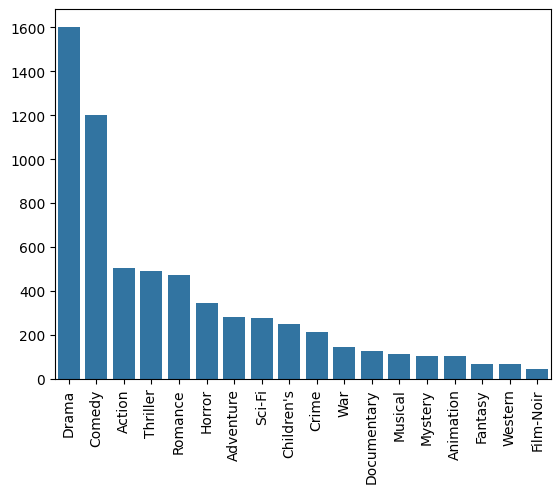

In [25]:
elements = dict(sorted(genre_counter.items(), key=lambda x: x[1], reverse=True))

sns.barplot(x=elements.keys(), y=elements.values())
plt.xticks(rotation=90)
plt.show()

In [26]:
# Hacemos el preprocesamiento del título para separa el título del año, creamos las columnas clean_title y year respectivamente
import re
movies['clean_title'] = movies['movie_title'].apply(lambda x: re.sub(r'\s*\([^)]*\)', '', x))

def extract_year(title):
    year = re.search(r'\((\d{4})\)', title)
    return int(year.group(1)) if year else None

movies['year'] = movies['movie_title'].apply(extract_year)

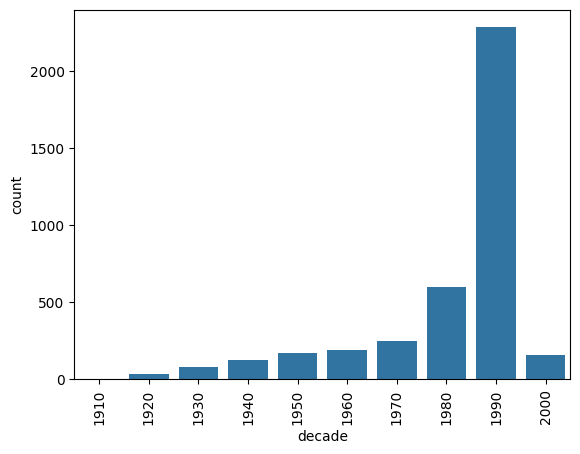

In [27]:
# tal como se recomendó en clase se creará una columna con la década de cada película de tal forma que la podamos utilizar como categoría en el sistema de recomendación
movies['decade'] = movies['year'].apply(lambda x: x - x%10)

plt.figure()
sns.barplot(movies['decade'].value_counts().sort_index()) # pending make bins
plt.xticks(rotation=90)
plt.show()

In [28]:
# A continuación transformamos a one hot encoding los generos para generar un vector de 1s y 0s para cada película dependiendo si pertenece o no a un género en particular
genres = list(genre_counter.keys())
for gender in genres:
    movies[gender] = movies['genres'].transform(lambda x: int(gender in x))

In [29]:
movies.head()

,movie_id,movie_title,genres,clean_title,year,decade,Animation,Children's,Comedy,Adventure,...,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",Toy Story,1995,1990,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]",Jumanji,1995,1990,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",Grumpier Old Men,1995,1990,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),"[Comedy, Drama]",Waiting to Exhale,1995,1990,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),[Comedy],Father of the Bride Part II,1995,1990,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
#  También las decadas las codificamos utilizando one-hot, pues representarán categorías en el algoritmo de recomendación
movie_decades = pd.get_dummies(movies['decade'])

In [31]:
movie_features = pd.concat([movies[genres], movie_decades], axis=1)
movie_features.head()

,Animation,Children's,Comedy,Adventure,Fantasy,Romance,Drama,Action,Crime,Thriller,...,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000
0,1,1,1,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
1,0,1,0,1,1,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
2,0,0,1,0,0,1,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
3,0,0,1,0,0,0,1,0,0,0,...,False,False,False,False,False,False,False,False,True,False
4,0,0,1,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False


In [32]:
# Realizamos una matriz de similitud item-item utilizando cosine similarity y considerando los géneros y las décadas como elementos del vector de características de cada película.
# nos queda una matriz de similaridad de (num_movies, num_movies)

from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(movie_features, movie_features)
similarity_matrix.shape

(3883, 3883)

In [33]:
# función para encontrar las películas más similares a una dada. Esta función es una utilidad que permite buscar el id de la película existente más cercana a un texto dado. Es útil en caso de que el nombre de la película no se escriba exactamente igual a como se llama en el dataset.

from fuzzywuzzy import process

title_to_idx = dict(zip(movies['movie_title'], list(movies.index)))
idx_to_title = {v:k for k,v in title_to_idx.items()}

def find_movie_idx(title):
    all_titles = movies['movie_title'].tolist()
    closest_match = process.extractOne(title, all_titles)
    return title_to_idx[closest_match[0]]

In [34]:
# ejemplo de una recomendcaión

movie_idx = 584 # aladin
recommendations_qty = 5
sim_scores = list(enumerate(similarity_matrix[movie_idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(recommendations_qty+1)]
similar_movies = [i[0] for i in sim_scores]
recommendations = [idx_to_title[x] for x in similar_movies]

In [35]:
recommendations

['Hercules (1997)',
 'Toy Story (1995)',
 'Lion King, The (1994)',
 'Nightmare Before Christmas, The (1993)',
 'Beauty and the Beast (1991)']

# Algoritmo complejo

In [36]:
# supervised complex system

# utilizaremos los ultimos ejemplos de cada usuario como parte del test set
ratings['latest_rank'] = ratings.groupby(['user_id'])['timestamp'].rank(method='first', ascending=False)
train_ratings = ratings[ratings['latest_rank'] != 1]
test_ratings = ratings[ratings['latest_rank'] == 1]

# conservamos unicamente user_id, movie_id, y rating
train_ratings = train_ratings[['user_id', 'movie_id', 'rating']]
test_ratings = test_ratings[['user_id', 'movie_id', 'rating']]



Muchas veces en vida real no tenemos una calificación explicita por parte del usuario sino que contamos con datos como si vio o no una película. Generaremos una columna con 1 si la vio y con 0 si no la vio. Se asume que si no la ha calificado, no está interesado en ella lo cual de acuerdo con la investigación indica que es lo que comúnmente se hace y funciona bien en la práctica.

No trataremos de predecir calificaciones sino si el usuario vera o no una película

In [37]:
train_ratings.loc[:, 'rating'] = 1

In [38]:
import torch
from torch.utils.data import Dataset

class RatingsDataset(Dataset):
    '''
    Dataset para generar los datos de entrenamiento para el modelo de deep learning.
    Toma como entraada los ratings de las peliculas y transforma las calificaciones existentes en etiquetas de que el usuario vio la pelicula y genera N ejemplos no existentes para etiquetas de que el usuario no vio la pelicula. Esto servirá para entrenar el modelo de deep learning.

    Args:
        ratings: dataframe de pandas con las calificaciones
        negative_examples_qty: cantidad de ejemplos negativos a generar
        all_movieids: lista de IDs de todas las peliculas disponibles, no solo en set de entrenamiento
    Returns:
        tupla con id de usuario, id de pelicula y etiqueta

    '''
    def __init__(self, ratings, negative_examples_qty, all_movieids):
        self.all_movieids = all_movieids
        self.negative_examples_qty = negative_examples_qty
        self.users, self.movies, self.labels = self._get_dataset(ratings, self.all_movieids)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.movies[idx], self.labels[idx]

    def _get_dataset(self, ratings, all_movieids):
        users, movies, labels = [], [], []

        # hacemos un set de pares, usuario - pelicula, no existen pares duplicados
        user_movie_set = set(zip(ratings['user_id'], ratings['movie_id']))

        for (user_id, movie_id) in user_movie_set:
            users.append(user_id)
            movies.append(movie_id)
            labels.append(1) # consideramos que si calificó la película, la vio
            for idx in range(self.negative_examples_qty):
                # selecciona una pelicula aleatoria
                negative_item = np.random.choice(all_movieids)
                # revisar que el usuario no haya interactuado con esta pelicula antes
                while (user_id, negative_item) in user_movie_set:
                    negative_item = np.random.choice(all_movieids)
                users.append(user_id)
                movies.append(negative_item)
                labels.append(0) # no vio la pelicula

        return users, movies, labels


In [39]:
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader

class DLRecommenderModel(pl.LightningModule):
    '''
    Sistema de recomendcaión que utiliza un modelo de deep learning para implementar un filtro colaborativo que modela una función de similaridad entre vectores (embeddings) de usuarios y películas.

    Args:
        n_users: cantidad de usuarios
        n_movies: cantidad de películas
        ratings: base de datos de calificaiones de peliculas
        all_movieids: lista de IDs de todas las peliculas disponibles, no solo en set de entrenamiento
        negative_examples_qty: cantidad de ejemplos negativos a generar por cada positivo
    '''

    _EMBEDDING_DIMENSIONS = 6

    def __init__(self, n_users, n_movies, ratings, all_movieids, negative_examples_qty):
        super().__init__() # llamamos al constructor de la clase padre
        self.negative_examples_qty = negative_examples_qty
        self.user_embedding = nn.Embedding(num_embeddings=n_users, embedding_dim=self._EMBEDDING_DIMENSIONS) # usamos capa Embedding de pytorch
        self.movie_embedding = nn.Embedding(num_embeddings=n_movies, embedding_dim=self._EMBEDDING_DIMENSIONS)

        # posterior a las capas embeddings se aplican dos capas densas, también llamadas Full connected.
        self.fc1 = nn.Linear(12, 64) # 12 features de entrada = 6 (de user embedding) + 6 (de movie embedding), 64 features de salida o neuronas
        self.fc2 = nn.Linear(64, 32) # 64 features de entrada, 32 features de salida
        self.fc3 = nn.Linear(32, 1) # 32 features de entrada, 1 feature de salida (prediccion)
        self.ratings = ratings.copy()
        self.all_movieids = all_movieids.copy()


    def forward(self, user_id, movie_id):
        # calculamos los embeddings
        user_embedding = self.user_embedding(user_id)
        movie_embedding = self.movie_embedding(movie_id)
        # concatenamos los embeddings de usuario y pelicula
        x = torch.cat([user_embedding, movie_embedding], dim=1)

        # aplicamos las capas densas
        x = nn.ReLU()(self.fc1(x)) # función de activación ReLU para capas intermedias
        x = nn.ReLU()(self.fc2(x))
        out = nn.Sigmoid()(self.fc3(x)) # función de activación sigmoide para obtener un valor entre 0 y 1 como salida final

        return out


    def training_step(self, batch, batch_idx):
        user_ids, movie_ids, labels = batch
        predictions = self(user_ids, movie_ids)
        # utilizaremos la función de pérdida Binary Cross Entropy, pues nuestro problema de clasificación es de tipo binario (dos clases)
        loss = nn.BCELoss()(predictions, labels.view(-1, 1).float())
        return loss

    def configure_optimizers(self):
        # utilizamos Adam como optimizador, se puede ajustar el learning rate
        return torch.optim.Adam(self.parameters(), lr=0.001)

    def train_dataloader(self):
        dataset = RatingsDataset(self.ratings, self.negative_examples_qty, self.all_movieids)
        return DataLoader(dataset, batch_size=512, num_workers=0)


In [40]:
# entrenamos el modelo

num_users = ratings['user_id'].max() + 1
num_items = ratings['movie_id'].max() + 1
all_movieids = ratings['movie_id'].unique()

model = DLRecommenderModel(num_users, num_items, train_ratings, all_movieids, negative_examples_qty=5)

trainer = pl.Trainer(max_epochs=6, logger=False, accelerator='mps', devices=1)
trainer.fit(model)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/moisesdiaz/miniconda3/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/moisesdiaz/github/MNA/BigData/avance2/checkpoints exists and is not empty.

  | Name            | Type      | Params
----------------------------------------------
0 | user_embedding  | Embedding | 36.2 K
1 | movie_embedding | Embedding | 23.7 K
2 | fc1             | Linear    | 832   
3 | fc2             | Linear    | 2.1 K 
4 | fc3             | Linear    | 33    
----------------------------------------------
62.9 K    Trainable params
0         Non-trainable params
62.9 K    Total params
0.252     Total estimated model params size (MB)
/Users/moisesdiaz/miniconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many work

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=6` reached.


### Métricas de evaluación de algoritmo complejo
#### 1. HitRatio@10

1. Para cada usuario seleccionamos de manera aleatoria 99 títulos de pelicula que el usuario no ha visto (en este caso que no ha evaluado). A estos 99 le sumamos la que el usuario ya vio. De esta forma tenemos 100 películas.

2. Ejecutamos la inferencia sobre estas 100 películas, ordenamos el resultado de las probabilidades de manera descendente y seleccionamos el top 10.

3. Si la película que ha visto está presente en el top 10, se considera un acierto y se le asigna un 1. En caso contrario se le asigna un 0.

4. Se repite el proceso para todos los usuarios y se hace el promedio de aciertos.

In [41]:
# evaluamos usando el set de prueba
user_interactions = set(zip(test_ratings['user_id'], test_ratings['movie_id']))
user_to_seen_movies_dict = ratings.groupby('user_id')['movie_id'].apply(list).to_dict()


hits = []
for (user_id, movie_id) in user_interactions:
    seen_movies = user_to_seen_movies_dict[user_id]
    non_seen_movies = set(all_movieids) - set(seen_movies)
    selected_movies = list(np.random.choice(list(non_seen_movies), 99))
    test_movies = selected_movies + [movie_id]

    predicted_labels = np.squeeze(model(torch.tensor([user_id]*100), torch.tensor(test_movies)).detach().numpy())

    top_10_idx = [test_movies[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()] # i puede ir de 0 a 100, convertimos a indice de pelicula

    if movie_id in top_10_idx:
        hits.append(1)
    else:
        hits.append(0)


print(f"HitRatio @ 10: {np.mean(hits)}")

HitRatio @ 10: 0.44834437086092715


In [42]:
from sklearn.metrics import precision_score

### **Precision@k**

Es una medida del cociente de los ítems recomendados entre los top k que son relevantes para el usuario.

P =Número de recomendaciones principales relevantes / Número de todos los elementos relevantes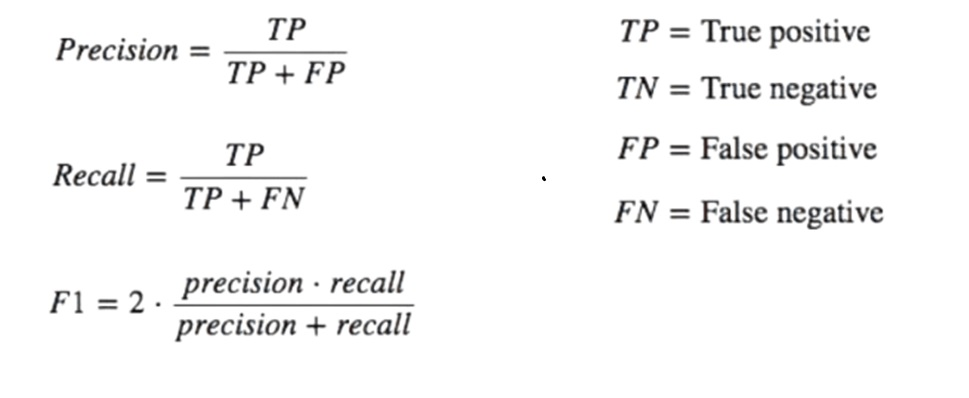

In [43]:
from sklearn.metrics import precision_score

precision_results = []

# Iterar sobre las interacciones de usuario y película en el conjunto de prueba
for (user_id, movie_id) in user_interactions:
    # Obtener las películas vistas por el usuario
    seen_movies = user_to_seen_movies_dict[user_id]
    # Calcular las películas no vistas por el usuario
    non_seen_movies = set(all_movieids) - set(seen_movies)
    # Seleccionar aleatoriamente 99 películas no vistas y agregar la película de prueba
    selected_movies = list(np.random.choice(list(non_seen_movies), 99))
    test_movies = selected_movies + [movie_id]

    # Realizar predicciones del modelo para las películas de prueba
    predicted_labels = np.squeeze(model(torch.tensor([user_id]*100), torch.tensor(test_movies)).detach().numpy())

    # Obtener los índices de las 10 películas principales
    top_10_idx = [test_movies[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]

    # Verificar si la película de prueba está entre las 10 principales
    if movie_id in top_10_idx:
        precision_results.append(1)
    else:
        precision_results.append(0)

precision_at_10 = np.mean(precision_results)

print(f"Precisión @ 10: {precision_at_10}")


Precisión @ 10: 0.454635761589404


### **F1@k**

Es la media armónica de precision@k y recall@k, que ayuda a simplificarlos en una única métrica.
Todas las métricas mencionadas anteriormente pueden calcularse con base en la matriz de confusión


In [44]:
from sklearn.metrics import f1_score

In [45]:

precision_results = []

for (user_id, movie_id) in user_interactions:
    # Obtener las películas vistas por el usuario
    seen_movies = user_to_seen_movies_dict[user_id]
    # Calcular las películas no vistas por el usuario
    non_seen_movies = set(all_movieids) - set(seen_movies)
    # Seleccionar aleatoriamente 99 películas no vistas y agregar la película de prueba
    selected_movies = list(np.random.choice(list(non_seen_movies), 99))
    test_movies = selected_movies + [movie_id]

    # Realizar predicciones del modelo para las películas de prueba
    predicted_labels = np.squeeze(model(torch.tensor([user_id]*100), torch.tensor(test_movies)).detach().numpy())

    # Obtener los índices de las 10 películas principales
    top_10_idx = [test_movies[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]

    # Verificar si la película de prueba está entre las 10 principales
    if movie_id in top_10_idx:
        precision_results.append(1)
    else:
        precision_results.append(0)


precision_at_10 = np.mean(precision_results)
recall_at_10 = np.mean(hits)

f1_at_10 = 2 * (precision_at_10 * recall_at_10) / (precision_at_10 + recall_at_10) if (precision_at_10 + recall_at_10) > 0 else 0

print(f"F1 @ 10: {f1_at_10}")

F1 @ 10: 0.4484271370360907


#### 2. Normalized Discounted Cumulative Gain (NDCG)

Mide que tan buena es una lista de recomendaciones tomando en cuenta el orden de la recomendación, en este caso toma en cuenta la posición de la película objetivo recomendada asignando una mejor calificación entre más arriba se encuentre en el ranking que regres.

# Propuesta: sistema de recomendacion hibrido

Combinaremos un sistema de recomendación de filtro colaborativo con el basado en contenido.
Para ello utilizaremos las siguientes condiciones, que en un futuro pueden ampliarse.

Condiciones:
1. Si el usuario es nuevo y no ha visto contenido realizaremos una recomendación global, el sistema más simple presentado en este documento, que implica recomendar lo más visto, productos populares.
2. Si el usuario no es nuevo pero tiene menos de 20 calificaciones de peliculas, utilizaremos el filtro basado en contenido. Es decir recomendaremos productos que son afines en características.
   -  En caso de que no exista la película buscaremos si existe el la base de datos imdb y recomendaremos por contenido utilizando esa base de datos.
3. Si las peliculas calificadas por un usuario son mayores a 20 utilizaremos el filtro colaborativo. Se recomendarán películas de acuerdo con el comportamiento del usuario.


In [46]:

def global_recommender(top_n):
    '''
    Recomendador global de películas.
    Hace recomendaciones generales con base en la popularidad de las películas, las más vistas. En este caso se considerarán como las mas vistas, las más veces calificadas.
    '''
    top_movies = ratings.value_counts('movie_id').sort_values(ascending=False).head(top_n)
    return [movieid_to_title[x] for x in top_movies.tolist()]


In [47]:
'''
Sistema de recomendación híbrido

'''

def make_recommendation(user_id, title, top_n=5):
    '''
    Recomendador de peliculas propuesto. Hace uso de 3 tipos de sistema de recomendación:
    - Recomendador global: basado en la popularidad global de las películas
    - Recomendador por contenido: basado en las características de las películas
    - Recomendador por usuario: basado en las películas que ha visto el usuario

    Args:
        user_id: id del usuario (required)
        title: título de la película (optional), si es su primera vez en la plataforma de streaming, no ha visto un título
        top_n: cantidad de recomendaciones a hacer
    Returns:
        lista de top_n recomendaciones
    '''
    USER_REVIEW_THRESHOLD = 20

    if ratings.loc[ratings['user_id'] == user_id, 'user_id'].count() > USER_REVIEW_THRESHOLD:
        # el usuario ha visto suficientes películas
        movie_idx = find_movie_idx(title)
        similar_idx = collaborative_filtering(1, user_movie_matrix, k=top_n, metric='cosine')
        return [movieid_to_title[movie_id] for (movie_id, _) in similar_idx[1:]]

    elif title:
        # el usuario ha visto pocas películas, utilizar filtro basado en contenido
        movie_idx = find_movie_idx(title)
        sim_scores = list(enumerate(similarity_matrix[movie_idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:(top_n+1)]
        similar_movies = [i[0] for i in sim_scores]
        return [idx_to_title[x] for x in similar_movies]

    if title is None:
        # no ha visto ninguna película
        return global_recommender(top_n)





In [48]:
# simulando un usuairo nuevo en la plataforma, sin contenido
user_id = 3021
make_recommendation(user_id, None, top_n=5)

['Champ, The (1979)',
 'Live and Let Die (1973)',
 'Licence to Kill (1989)',
 'Mumford (1999)',
 'Thirteenth Floor, The (1999)']

In [49]:
# simulando un usuario con suficientes reviews (utiliza filtro colaborativo)
user_id = 1
make_recommendation(user_id, "Toy Story", top_n=5)

['Toy Story 2 (1999)',
 'Groundhog Day (1993)',
 'Aladdin (1992)',
 "Bug's Life, A (1998)",
 'Back to the Future (1985)']

In [50]:
# simulando un usuario con pocos reviews (utiliza filtro basado en contenido)
user_id = 3021
make_recommendation(user_id, "Aladin", top_n=5)

['Hercules (1997)',
 'Toy Story (1995)',
 'Lion King, The (1994)',
 'Nightmare Before Christmas, The (1993)',
 'Beauty and the Beast (1991)']